In [1]:
#Defining Geographical Rating Territories in Auto Insurance Regulation by Spatially Constrained Clustering (Shengkun Xie)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline 

In [3]:
from sklearn.model_selection import train_test_split
dfFull=pd.read_csv('clean_brvehins.csv')
#this setting is the same as the one used for GLM model fitting. the GLM output is using the train data
train,test = train_test_split(dfFull, test_size=0.3, random_state=42) 


In [4]:
dfData=pd.read_csv('1_GLM_output.csv')
dfData.head()

,Gender,DrivAge,VehYear,VehGroup,Area,State,_EXPO,_Cnt,_Freq,_Sev,_Amt,lat,long,residual,Pred_Cnt
0,Male,46-55,2005.0,Ford Eco Sport,MET. FLORIANOPOLIS E SUL,Santa Catarina,1.00,0.0,0.000000,0.0,0.0,-27.319934,-50.614537,-0.563147,0.158568
1,Male,46-55,2009.0,Honda Fit,VALE DO ACO-NORTE-VALE JEQUITINHONHA,Minas Gerais,1.00,0.0,0.000000,0.0,0.0,-18.455751,-44.672987,-0.662326,0.219338
2,Female,26-35,2005.0,Ford Fiesta 1.0,MET.BH-CENTRO OESTE-ZONA MATA-C. VERTENTES,Minas Gerais,1.00,1.0,0.072411,1864.0,1864.0,-18.468580,-44.693059,1.334608,0.180927
3,Male,36-45,1997.0,Fiat Fiorino,DEMAIS REGIOES,Parana,0.79,0.0,0.000000,0.0,0.0,-26.542285,-51.849841,-0.413157,0.085350
4,Male,>55,1995.0,Mercedes-benz Caminhoes - Outros,GRANDE CAMPINAS,Sao Paulo,1.00,0.0,0.000000,0.0,0.0,-20.366281,-47.068379,-0.380143,0.072254


In [5]:
dfArea=dfData[['Area','_EXPO','_Cnt', '_Amt', 'lat', 'long', 'residual', 'Pred_Cnt']].assign(
    res2=lambda x:x['residual']**2).groupby(
    'Area', as_index=False).agg(
    EXPO=('_EXPO', 'sum'), CNT=('_Cnt', 'sum'),AMT=('_Amt', 'sum'),PRED_CNT=('Pred_Cnt', 'sum'),res=('res2', 'sum'),
    lat=('lat', 'mean'),long=('long', 'mean'))
dfArea.head()

,Area,EXPO,CNT,AMT,PRED_CNT,res,lat,long
0,ACRE,1601.74,217.0,1.211748e+06,372.235086,1122.386584,-9.213962,-70.470687
1,ALAGOAS,6643.61,1062.0,6.456523e+06,1433.457150,4256.961648,-10.301998,-37.180574
2,AMAPA,1083.85,163.0,1.185815e+06,263.159206,825.221717,1.764419,-50.580957
3,AMAZONAS,4488.61,727.0,3.606137e+06,1017.275529,3002.018509,-4.153818,-64.652582
4,BAHIA,15436.87,3185.0,2.250799e+07,3140.510682,10224.125970,-12.610508,-41.807392


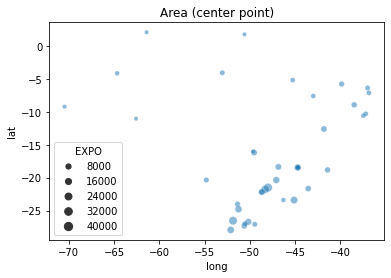

In [6]:
sns.scatterplot(data=dfArea, x='long', y='lat', alpha=0.5, size='EXPO').set(title='Area (center point)');

In [7]:
def update_weight(value,long,lat,w_value, w_lat, w_long):
    w_value_=np.sqrt(w_value)  
    w_long_=np.sqrt(w_long)
    w_lat_=np.sqrt(w_lat)
    array_w_value = w_value_* value
    array_w_long = w_long_* long
    array_w_lat = w_lat_* lat
    return pd.concat([array_w_value,array_w_long,array_w_lat],axis=1)



In [8]:
# Gap Statistic for K means
# https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
def optimalK(data, nrefs=3, maxClusters=15, seed=0):
    np.random.seed(seed=seed)
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []
    randomReference = np.random.random_sample((data.shape[0],data.shape[1],nrefs))          
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):         
            km = KMeans(k)
            km.fit(randomReference[:,:,i])            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.mean(np.log(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap        
        results.append([k, gap])
    return (gaps.argmax() + 1, pd.DataFrame(results, columns=['clusterCount', 'gap']))

In [9]:
def create_silhouette_plot (ax, data, maxClusters=15, seed=0):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    kmeans = KMeans(n_clusters = maxClusters, init = "k-means++", random_state = seed)
    cls_kmeans = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cls_kmeans)
    print("For n_clusters ={:d}, The average silhouette_score is : {:.4f}".format(maxClusters,silhouette_avg))
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cls_kmeans)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, data.shape[0] + (maxClusters + 1) * 10])      
    y_lower = 10
    for i in range(maxClusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cls_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / maxClusters)
        out = ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax.set_title("Silhouette Plot")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("clusters")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    return out

In [10]:
def plot_cluster_result(model, data, ax, label=True):
    cls_kmeans = model.fit_predict(data)
    out=sns.scatterplot(
        data=data, x='long', y='lat', markers=".", s=50, lw=0, alpha=0.7, hue=cls_kmeans, palette='tab10', ax=ax)
    if label:
        centers = pd.DataFrame(model.cluster_centers_, columns=data.columns)
        # Draw white circles at cluster centers
        ax.scatter(centers['long'], centers['lat'], marker="o", c="white", alpha=1,s=200,edgecolor="k",)
        for index, row in centers.iterrows():
            ax.scatter(row['long'], row['lat'], marker="$%d$" % index, alpha=1, s=50, edgecolor="k")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Cluster Result")
    ax.legend(title='cluster')
    return out

#### 1. use Count to fit cluster

In [11]:
value_='CNT'

In [12]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_scale = pd.DataFrame(scale.fit_transform(dfArea[[value_,'long','lat']]), columns=[value_,'long','lat'])
X_scale.describe()

,CNT,long,lat
count,4.000000e+01,4.000000e+01,4.000000e+01
mean,-3.330669e-17,3.996803e-16,-1.776357e-16
std,1.012739e+00,1.012739e+00,1.012739e+00
min,-1.067303e+00,-3.049618e+00,-1.390171e+00
25%,-6.557082e-01,-3.661681e-01,-7.435698e-01
50%,-3.269333e-01,-6.818351e-03,-2.614497e-01
75%,3.992703e-01,5.032000e-01,8.482901e-01
max,3.488251e+00,1.532730e+00,2.185726e+00


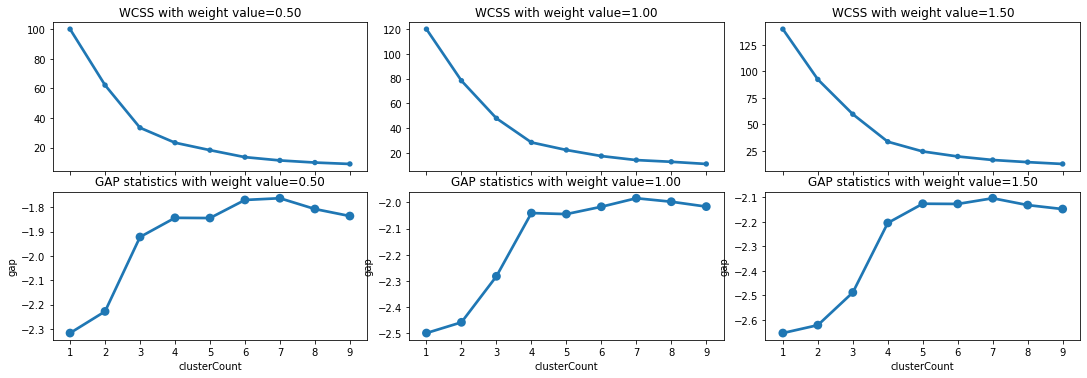

In [13]:
fig,axs=plt.subplots(2,3,figsize=(5*3,5),sharey=False, sharex=True)
fig.tight_layout()
for w in range(1,4):
    w_value_= w*0.5
    X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                           w_value=w_value_, w_lat=1, w_long=1)
    wcss = [] 
    max_cls=10
    for i in range(1, max_cls): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 22)
        kmeans.fit(X_scale_wtd) 
        wcss.append(kmeans.inertia_)
    sns.pointplot(x=np.array(range(1,max_cls)),y=np.array(wcss), markers='.', ax=axs[0][w-1]).set(
        title='WCSS with weight value={:.2f}'.format(w_value_));
    
    score_g, df = optimalK(X_scale_wtd, nrefs=10, maxClusters=max_cls)
    sns.pointplot(x=df['clusterCount'],y=df['gap'], markers='o', ax=axs[1][w-1]).set(
        title='GAP statistics with weight value={:.2f}'.format(w_value_));


For n_clusters =5, The average silhouette_score is : 0.4518
For n_clusters =6, The average silhouette_score is : 0.3926
For n_clusters =7, The average silhouette_score is : 0.3846
For n_clusters =5, The average silhouette_score is : 0.3917
For n_clusters =6, The average silhouette_score is : 0.3788
For n_clusters =7, The average silhouette_score is : 0.3738
For n_clusters =5, The average silhouette_score is : 0.4102
For n_clusters =6, The average silhouette_score is : 0.4020
For n_clusters =7, The average silhouette_score is : 0.3757


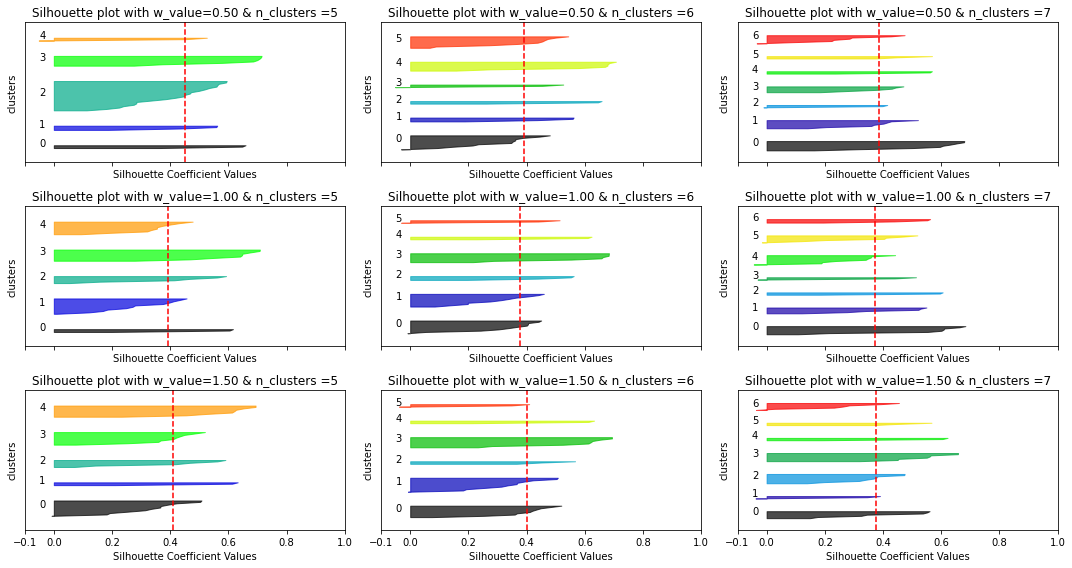

In [14]:
fig,axs=plt.subplots(3,3,figsize=(5*3,8),sharey=False, sharex=True)
for w in range(3):
    w_value_= (w+1)*0.5
    X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                           w_value=w_value_, w_lat=1, w_long=1)
    for i in range(3): 
        max_cls=5+i
        create_silhouette_plot (ax=axs[w][i],data=X_scale_wtd, maxClusters=max_cls, seed=42)
        axs[w][i].set_title("Silhouette plot with w_value={:.2f} & n_clusters ={:d}".format(
                w_value_, max_cls))
fig.tight_layout()
plt.show();


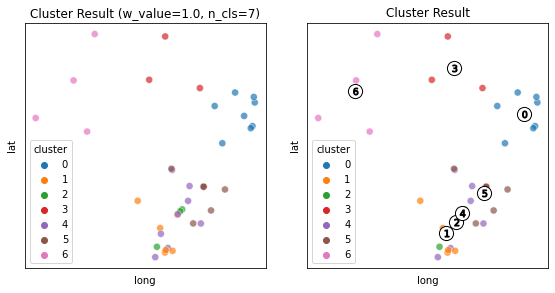

In [15]:
fig,axs=plt.subplots(1,2,figsize=(4*2,4),sharey=False, sharex=False)
fig.tight_layout()
w_value_=1
n_cls_=7
X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                       w_value=w_value_, w_lat=1, w_long=1)
kmeans = KMeans(n_clusters = n_cls_, init = "k-means++", random_state = 42)
cls_kmeans = kmeans.fit_predict(X_scale_wtd)
plot_cluster_result(model=kmeans, data=X_scale_wtd, ax=axs[0], label=False);
axs[0].set_title('Cluster Result (w_value={:.1f}, n_cls={:d})'.format(w_value_,n_cls_));
plot_cluster_result(model=kmeans, data=X_scale_wtd, ax=axs[1], label=True);

##### Update boundary

interation 1: 13 points updated


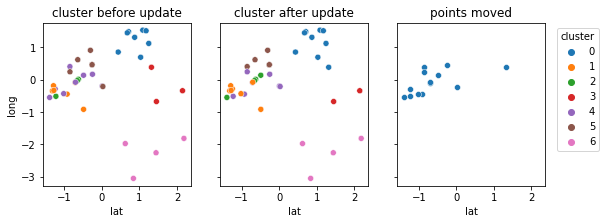

interation 2: 7 points updated


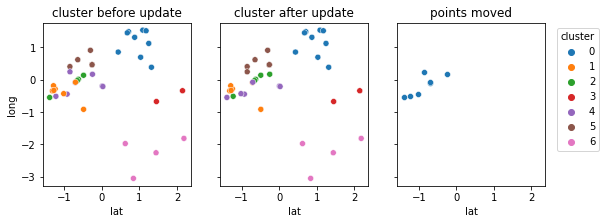

interation 3: 5 points updated


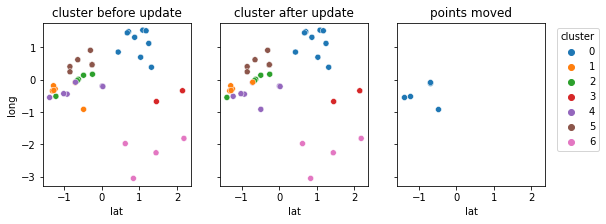

interation 4: 4 points updated


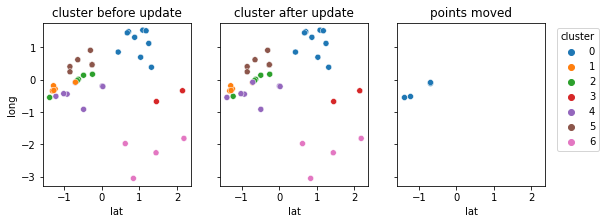

interation 5: 4 points updated


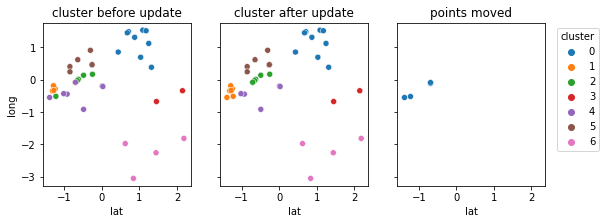

In [16]:
import scipy.spatial as spatial
points=X_scale[['lat', 'long']].apply(list, axis=1).tolist()
point_tree = spatial.cKDTree(points,leafsize=100)

max_iter_=10
cls_before_=cls_kmeans
i=0
flag=True
updated_pt=[]
while ((i < max_iter_) & flag):
    i += 1
    #if none of the closest 3 neighbour points are from the same cluster, then it's isolated, judge by the plot, 3 is sufficient
    isolated=[[(np.array(cls_before_)[point_tree.query(points[p],k=3)[1].tolist()]==cls_before_[p]).sum()==1,p]
              for p in range(len(points))]
    updated_cls=[cls_before_[p] if ~isolated[p][0] else
                 cls_before_[point_tree.query(points[p],k=2)[1][1]] for p in range(len(points))]
    if [isolated[p][1] for p in range(len(points)) if isolated[p][0]]==updated_pt:
        flag=False  #the list of points being updated is the same as last iteration
        updated_cls=[cls_before_[p] if ~isolated[p][0] else
                 cls_before_[point_tree.query(points[p],k=3)[1][2]] for p in range(len(points))]
    else:
        updated_pt=[isolated[p][1] for p in range(len(points)) if isolated[p][0]]

    print("interation {:d}: {:d} points updated".format(i, len(updated_pt)))
    fig,axs=plt.subplots(1,3,figsize=(9,3),sharey=True, sharex=True)
    sns.scatterplot(data=X_scale, x='lat',y='long',palette= 'tab10', hue=cls_before_, ax=axs[0]).set(
        title="cluster before update");
    sns.scatterplot(data=X_scale, x='lat',y='long',palette= 'tab10', hue=updated_cls, ax=axs[1], legend=False).set(
        title="cluster after update");
    sns.scatterplot(data=X_scale.iloc[updated_pt,], x='lat',y='long',ax=axs[2]).set(
        title="points moved");
    axs[0].legend(loc="upper right", bbox_to_anchor=(3.8,1),title='cluster')
    plt.show();
    
    cls_before_=updated_cls


In [17]:
dictClsMap=dict(zip(dfArea['Area'], np.array(updated_cls).astype('str')))
dfData['cls']=dfData['Area'].str.upper().map(dictClsMap)
dfSummary=dfData.groupby('cls', as_index=False)['_EXPO'].sum().rename(columns={'_EXPO':'Expo_Train'})

#test data
test['cls']=test['Area'].str.upper().map(dictClsMap)
dfSummary['Expo_Test']=test.groupby('cls')['_EXPO'].sum().values
display(dfSummary)
del dfSummary

,cls,Expo_Train,Expo_Test
0,0,76136.31,32575.20
1,1,118289.71,50884.07
2,2,144460.28,61739.05
3,3,8469.31,3628.39
4,4,62901.71,27096.89
5,5,111446.16,47808.88
6,6,7876.84,3378.14


In [18]:
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

for e in ['',' + cls']:
    expr_ = "_Cnt ~ VehYear + Gender * DrivAge" + e
    print(expr_)
    y, X = dmatrices(expr_, data=dfData, return_type='dataframe')
    FreqPoisson = sm.GLM(endog=y, exog=X, offset=np.log(dfData['_EXPO']),
                          family=sm.families.Poisson(link=sm.families.links.log())).fit()
    y_test, X_test = dmatrices(expr_, data=test, return_type='dataframe')
    pred_test=FreqPoisson.predict(X_test)
    print("deviance: {:.1f}, BIC:  {:.1f}, AIC {:.1f}".format(FreqPoisson.deviance, FreqPoisson.bic_llf, FreqPoisson.aic))
    print("Total Count - Train: actual {:.2f}, predicted {:.2f}; Test: actual {:.2f}, predicted {:.2f}".format(
        y.values.sum(), FreqPoisson.fittedvalues.sum(), y_test.values.sum(), pred_test.values.sum()))
    print("RMSE - Train: {:.4f}, Test: {:.4f} \nRMAE - Train: {:.4f}, Test: {:.4f}".format(
        MSE(y_true=y, y_pred=FreqPoisson.fittedvalues, sample_weight=dfData['_EXPO']),
        MSE(y_true=y_test, y_pred=pred_test, sample_weight=test['_EXPO']),
        MAE(y_true=y, y_pred=FreqPoisson.fittedvalues, sample_weight=dfData['_EXPO']),
        MAE(y_true=y_test, y_pred=pred_test, sample_weight=test['_EXPO']),
    ))

_Cnt ~ VehYear + Gender * DrivAge
deviance: 346689.8, BIC:  548954.1, AIC 548827.1
Total Count - Train: actual 102301.00, predicted 102301.00; Test: actual 44060.00, predicted 62311.07
RMSE - Train: 0.1449, Test: 0.1526 
RMAE - Train: 0.2716, Test: 0.2991
_Cnt ~ VehYear + Gender * DrivAge + cls
deviance: 345152.6, BIC:  547498.1, AIC 547301.8
Total Count - Train: actual 102301.00, predicted 102301.00; Test: actual 44060.00, predicted 61890.20
RMSE - Train: 0.1444, Test: 0.1520 
RMAE - Train: 0.2708, Test: 0.2978


#### 2. use deviance


In [19]:
value_='res'

In [20]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_scale = pd.DataFrame(scale.fit_transform(dfArea[[value_,'long','lat']]), columns=[value_,'long','lat'])
X_scale.describe()

,res,long,lat
count,4.000000e+01,4.000000e+01,4.000000e+01
mean,3.330669e-17,3.996803e-16,-1.776357e-16
std,1.012739e+00,1.012739e+00,1.012739e+00
min,-1.190393e+00,-3.049618e+00,-1.390171e+00
25%,-6.854247e-01,-3.661681e-01,-7.435698e-01
50%,-2.959672e-01,-6.818351e-03,-2.614497e-01
75%,4.732925e-01,5.032000e-01,8.482901e-01
max,3.140797e+00,1.532730e+00,2.185726e+00


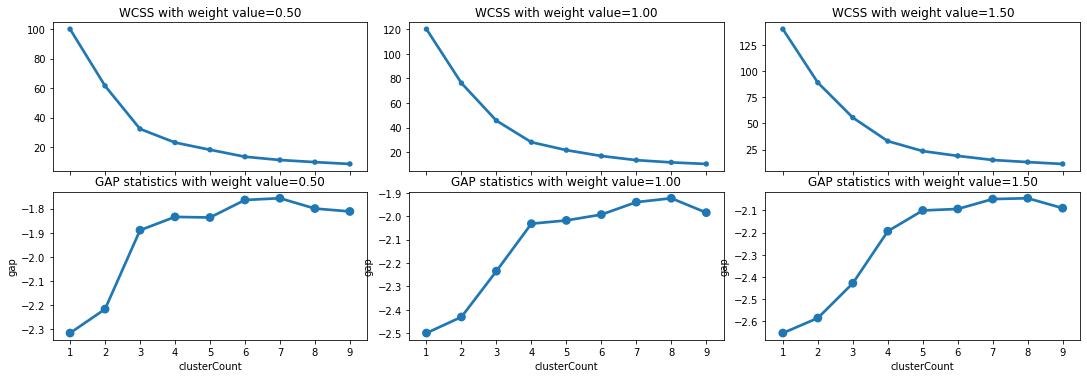

In [21]:
fig,axs=plt.subplots(2,3,figsize=(5*3,5),sharey=False, sharex=True)
fig.tight_layout()
for w in range(1,4):
    w_value_= w*0.5
    X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                           w_value=w_value_, w_lat=1, w_long=1)
    wcss = [] 
    max_cls=10
    for i in range(1, max_cls): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 22)
        kmeans.fit(X_scale_wtd) 
        wcss.append(kmeans.inertia_)
    sns.pointplot(x=np.array(range(1,max_cls)),y=np.array(wcss), markers='.', ax=axs[0][w-1]).set(
        title='WCSS with weight value={:.2f}'.format(w_value_));
    
    score_g, df = optimalK(X_scale_wtd, nrefs=10, maxClusters=max_cls)
    sns.pointplot(x=df['clusterCount'],y=df['gap'], markers='o', ax=axs[1][w-1]).set(
        title='GAP statistics with weight value={:.2f}'.format(w_value_));


For n_clusters =6, The average silhouette_score is : 0.3979
For n_clusters =7, The average silhouette_score is : 0.3838
For n_clusters =8, The average silhouette_score is : 0.3587
For n_clusters =6, The average silhouette_score is : 0.3854
For n_clusters =7, The average silhouette_score is : 0.3807
For n_clusters =8, The average silhouette_score is : 0.3772
For n_clusters =6, The average silhouette_score is : 0.4097
For n_clusters =7, The average silhouette_score is : 0.3903
For n_clusters =8, The average silhouette_score is : 0.3796


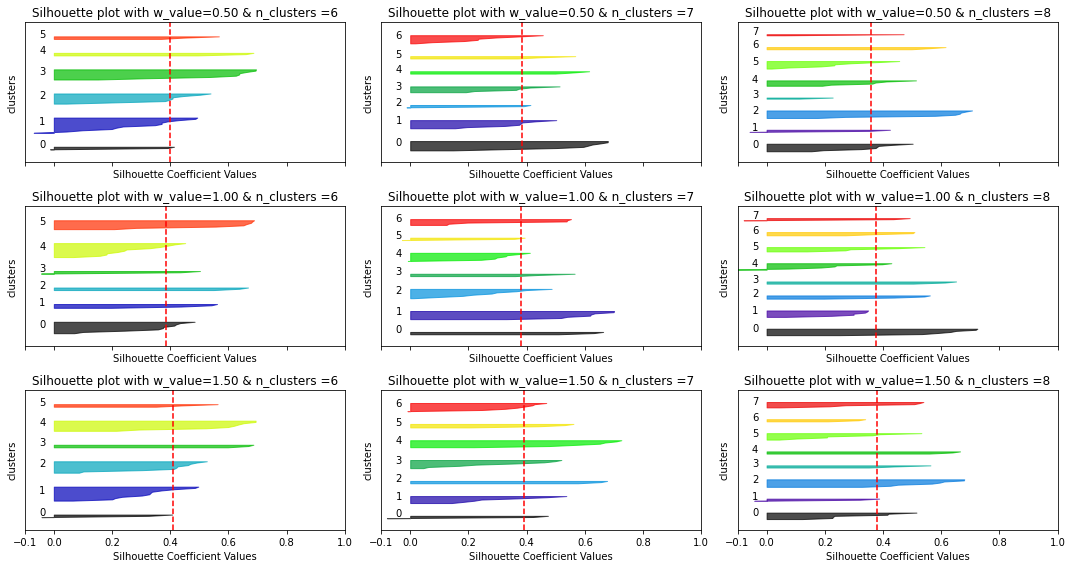

In [22]:
fig,axs=plt.subplots(3,3,figsize=(5*3,8),sharey=False, sharex=True)
for w in range(3):
    w_value_= (w+1)*0.5
    X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                           w_value=w_value_, w_lat=1, w_long=1)
    for i in range(3): 
        max_cls=6+i
        create_silhouette_plot (ax=axs[w][i],data=X_scale_wtd, maxClusters=max_cls, seed=42)
        axs[w][i].set_title("Silhouette plot with w_value={:.2f} & n_clusters ={:d}".format(
                w_value_, max_cls))
fig.tight_layout()
plt.show();


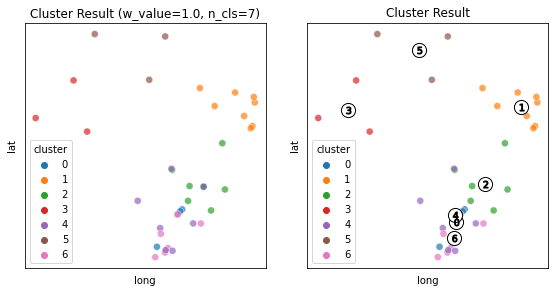

In [23]:
fig,axs=plt.subplots(1,2,figsize=(4*2,4),sharey=False, sharex=False)
fig.tight_layout()
w_value_=1
n_cls_=7
X_scale_wtd= update_weight(value=X_scale[value_],long=X_scale['long'],lat=X_scale['lat'],
                       w_value=w_value_, w_lat=1, w_long=1)
kmeans = KMeans(n_clusters = n_cls_, init = "k-means++", random_state = 42)
cls_kmeans = kmeans.fit_predict(X_scale_wtd)
plot_cluster_result(model=kmeans, data=X_scale_wtd, ax=axs[0], label=False);
axs[0].set_title('Cluster Result (w_value={:.1f}, n_cls={:d})'.format(w_value_,n_cls_));
plot_cluster_result(model=kmeans, data=X_scale_wtd, ax=axs[1], label=True);

interation 1: 12 points updated


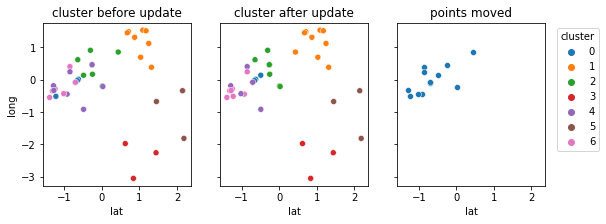

interation 2: 6 points updated


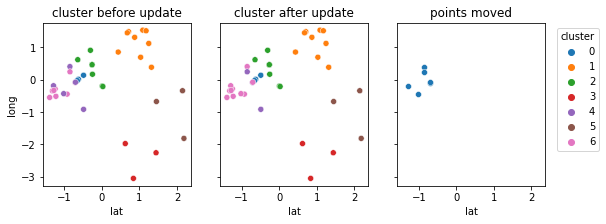

interation 3: 5 points updated


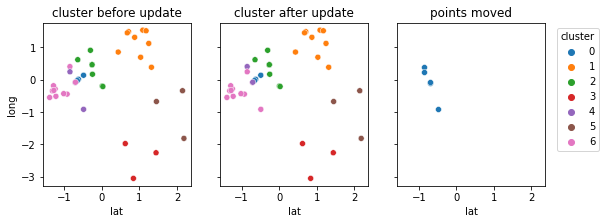

interation 4: 4 points updated


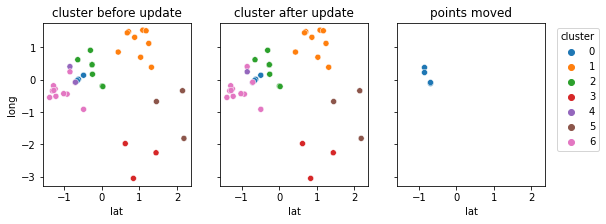

interation 5: 4 points updated


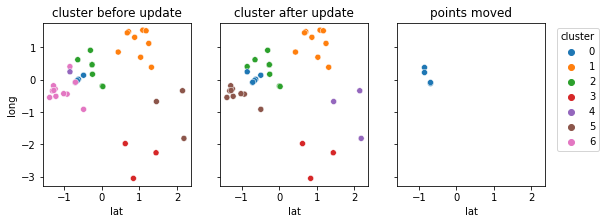

In [24]:
import scipy.spatial as spatial
points=X_scale[['lat', 'long']].apply(list, axis=1).tolist()
point_tree = spatial.cKDTree(points,leafsize=100)

max_iter_=10
cls_before_=cls_kmeans
i=0
flag=True
updated_pt=[]
while ((i < max_iter_) & flag):
    i += 1
    #if none of the closest 3 neighbour points are from the same cluster, then it's isolated, judge by the plot, 3 is sufficient
    isolated=[[(np.array(cls_before_)[point_tree.query(points[p],k=3)[1].tolist()]==cls_before_[p]).sum()==1,p]
              for p in range(len(points))]
    updated_cls=[cls_before_[p] if ~isolated[p][0] else
                 cls_before_[point_tree.query(points[p],k=2)[1][1]] for p in range(len(points))]
    if [isolated[p][1] for p in range(len(points)) if isolated[p][0]]==updated_pt:
        flag=False  #the list of points being updated is the same as last iteration
        updated_cls=[cls_before_[p] if ~isolated[p][0] else
                 cls_before_[point_tree.query(points[p],k=3)[1][2]] for p in range(len(points))]
    else:
        updated_pt=[isolated[p][1] for p in range(len(points)) if isolated[p][0]]

    print("interation {:d}: {:d} points updated".format(i, len(updated_pt)))
    fig,axs=plt.subplots(1,3,figsize=(9,3),sharey=True, sharex=True)
    sns.scatterplot(data=X_scale, x='lat',y='long',palette= 'tab10', hue=cls_before_, ax=axs[0]).set(
        title="cluster before update");
    sns.scatterplot(data=X_scale, x='lat',y='long',palette= 'tab10', hue=updated_cls, ax=axs[1], legend=False).set(
        title="cluster after update");
    sns.scatterplot(data=X_scale.iloc[updated_pt,], x='lat',y='long',ax=axs[2]).set(
        title="points moved");
    axs[0].legend(loc="upper right", bbox_to_anchor=(3.8,1),title='cluster')
    plt.show();
    
    cls_before_=updated_cls


In [25]:
dictClsMap=dict(zip(dfArea['Area'], np.array(updated_cls).astype('str')))
dfData['cls']=dfData['Area'].str.upper().map(dictClsMap)
dfSummary=dfData.groupby('cls', as_index=False)['_EXPO'].sum().rename(columns={'_EXPO':'Expo_Train'})

#test data
test['cls']=test['Area'].str.upper().map(dictClsMap)
dfSummary['Expo_Test']=test.groupby('cls')['_EXPO'].sum().values
display(dfSummary)
del dfSummary

,cls,Expo_Train,Expo_Test
0,0,131696.17,56445.88
1,1,76136.31,32575.20
2,2,143346.15,61451.27
3,3,6904.24,2938.75
4,5,9441.91,4067.78
5,6,162055.54,69631.74


In [26]:
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

for e in ['',' + cls']:
    expr_ = "_Cnt ~ VehYear + Gender * DrivAge" + e
    print(expr_)
    y, X = dmatrices(expr_, data=dfData, return_type='dataframe')
    FreqPoisson = sm.GLM(endog=y, exog=X, offset=np.log(dfData['_EXPO']),
                          family=sm.families.Poisson(link=sm.families.links.log())).fit()
    y_test, X_test = dmatrices(expr_, data=test, return_type='dataframe')
    pred_test=FreqPoisson.predict(X_test)
    print("deviance: {:.1f}, BIC:  {:.1f}, AIC {:.1f}".format(FreqPoisson.deviance, FreqPoisson.bic_llf, FreqPoisson.aic))
    print("Total Count - Train: actual {:.2f}, predicted {:.2f}; Test: actual {:.2f}, predicted {:.2f}".format(
        y.values.sum(), FreqPoisson.fittedvalues.sum(), y_test.values.sum(), pred_test.values.sum()))
    print("RMSE - Train: {:.4f}, Test: {:.4f} \nRMAE - Train: {:.4f}, Test: {:.4f}".format(
        MSE(y_true=y, y_pred=FreqPoisson.fittedvalues, sample_weight=dfData['_EXPO']),
        MSE(y_true=y_test, y_pred=pred_test, sample_weight=test['_EXPO']),
        MAE(y_true=y, y_pred=FreqPoisson.fittedvalues, sample_weight=dfData['_EXPO']),
        MAE(y_true=y_test, y_pred=pred_test, sample_weight=test['_EXPO']),
    ))

_Cnt ~ VehYear + Gender * DrivAge
deviance: 346689.8, BIC:  548954.1, AIC 548827.1
Total Count - Train: actual 102301.00, predicted 102301.00; Test: actual 44060.00, predicted 62311.07
RMSE - Train: 0.1449, Test: 0.1526 
RMAE - Train: 0.2716, Test: 0.2991
_Cnt ~ VehYear + Gender * DrivAge + cls
deviance: 345480.6, BIC:  547812.5, AIC 547627.8
Total Count - Train: actual 102301.00, predicted 102301.00; Test: actual 44060.00, predicted 61944.43
RMSE - Train: 0.1446, Test: 0.1521 
RMAE - Train: 0.2710, Test: 0.2981
